# Feature Engineering

## Overview

In this notebook we will look at features we can create, as well as remove to improve the performace on our model. We only have ~10,000 training examples so we don't want to add too many columns. 

---
### Load libraries and data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
train = pd.read_csv('data/cleaned_train.csv')
test = pd.read_csv('data/cleaned_test.csv')
train_len = len(train)
df = pd.concat([train, test], sort=False)

### Remove squared columns
These are only useful for linear models 

In [34]:
squared_cols = [col for col in df.columns if col.startswith('SQB')]
df.drop(squared_cols + ['agesq'], axis=1, inplace=True)

### Household aggregate functions

Age and education levels of all household members are important to determining the poverty level of an individual. It's helpful to aggregate these features on a household level.

In [25]:
aggs = {'age':['mean', 'max', 'min', 'std'],
        'escolari':['mean', 'max', 'min', 'std']}

hogar_groups = train.groupby(['idhogar'])
for agg_col, agg_funcs in aggs.items():
    for agg_func in agg_funcs:
        df['household_{}_{}'.format(agg_col, agg_func)] = hogar_groups[agg_col].transform(agg_func)

### New Features

We don't want to add too many features. Household figures relating to gender, age, and overcrowding were shown to be important so we'll add a few in here.

In [35]:
df['household_child_ratio'] = df.hogar_nin / df.hogar_total
df['household_women_ratio'] = df.r4m3 / df.r4t3
df['rent_per_room'] = df.v2a1 / df.rooms
df['rent_per_adult'] = df.v2a1 / df.hogar_adul
df['adult_per_room'] = df.hogar_adul / df.rooms
df['child_per_room'] = df.hogar_nin / df.rooms

### Remove columns with very high correlations

These variables can be harmful to the performance of tree ensemble models.

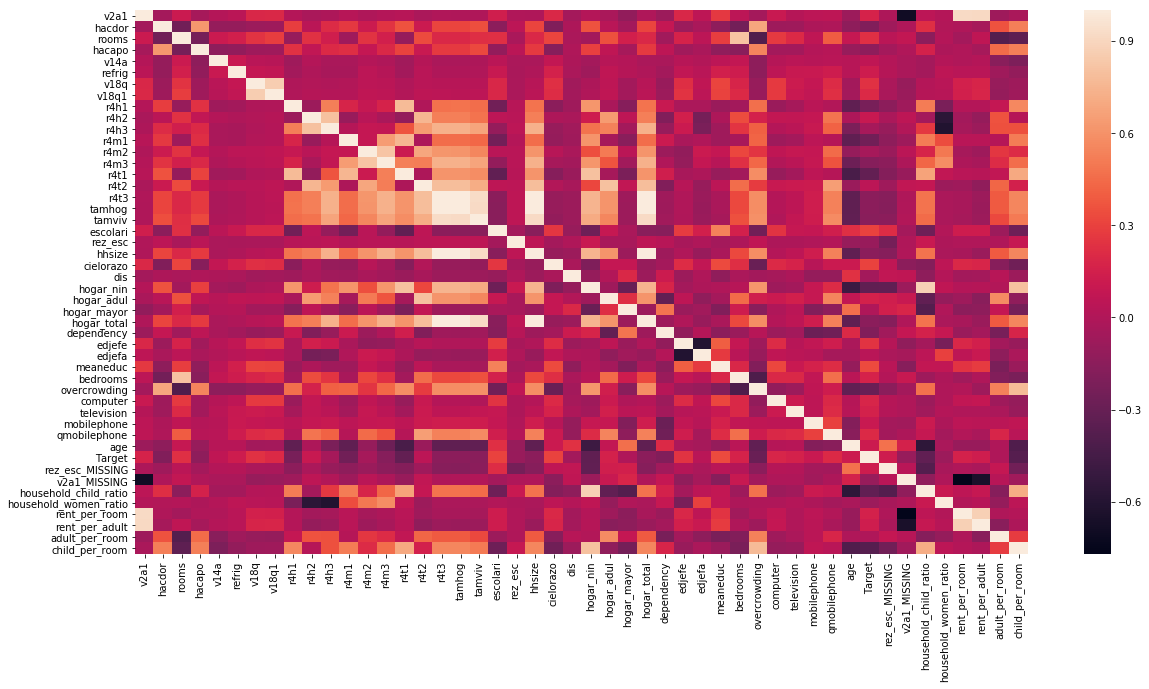

In [36]:
corr = df.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax=ax)
plt.show()

In [37]:
print((df.tamhog - df.hogar_total).value_counts(), '\n')
print((df.tamviv - df.hogar_total).value_counts(), '\n')
print((df.r4t3 - df.hogar_total).value_counts(), '\n')

0    33413
dtype: int64 

0     32274
1       250
2       248
3       225
4       174
5        71
6        57
7        42
8        36
9        30
13        6
dtype: int64 

0    33264
1      132
2       11
3        6
dtype: int64 



In [38]:
df.drop(['r4t3', 'tamhog'], axis=1, inplace=True)
df['tamviv_diff'] = df.tamviv - df.hogar_total

### Resplit data and save

In [39]:
final_train = df[:train_len]
final_test = df[train_len:]

print('final train shape: ', final_train.shape)
print('final test shape: ', final_test.shape)

final train shape:  (9557, 67)
final test shape:  (23856, 67)


In [40]:
final_train.to_csv('data/final_train.csv', index=False)
final_test.to_csv('data/final_test.csv', index=False)